In [3]:
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum

$$ df/dx = k_n \cdot m^{n_c} - k_a \cdot m \cdot f$$

In [56]:

class Event(Enum):
    NUCLEATION = 0
    ASSOCIATION = 1



class Gillespie:
    def __init__(self, k_nucleation, k_association):
        self.n_c = 3

        self.n_0 = 100000/2

        self.k_nucleation = k_nucleation
        self.k_association = k_association

        self.reset()

    def reset(self,):
        self.polymers = []
        self.polymers_over_time = []
        self.n = self.n_0

        self.update()

    def update(self,):

        self.m = self.n / self.n_c
        self.rate_nucleation = self.k_nucleation * (self.m ** self.n_c)
        self.rate_association = self.k_association * self.m

        
    

    def get_gillespie_time(self, rate):
        return - np.log(np.random.rand())/rate


    def get_rates(self,):
        rates = [self.rate_nucleation] + [self.rate_association] * len(self.polymers)
        return np.array(rates)


    def get_event_choice(self, all_rates):

        return np.random.choice(
            [Event.NUCLEATION] + [Event.ASSOCIATION] * len(self.polymers),
            p = all_rates / np.sum(all_rates)
            )
    
    
        
    
    def run(self):

        self.reset()

        t = 0.0

        step_i = 0  
        while True:
            if self.n <= 0:
                print("No more monomers left.")
                break


            all_rates = self.get_rates()
            total_rate = np.sum(all_rates)
            dt = self.get_gillespie_time(total_rate)
            t += dt

            event_type = self.get_event_choice(all_rates)

            match event_type:
                case Event.NUCLEATION:
                    self.polymers.append(self.n_c)
                    self.n -= self.n_c
                
                case Event.ASSOCIATION:
                    random_index = np.random.randint(0, len(self.polymers))
                    self.polymers[random_index] += 1
                    self.n -= 1

                case _:
                    assert False, "Unknown event type"

            self.polymers_over_time.append(self.polymers.copy())
            self.update()
            
            step_i += 1

        print(f"Final time: {t:.2f}, after {step_i} steps")
        print(f"Final number of polymers: {len(self.polymers)}")






In [57]:

G = Gillespie(1, 1000000)

G.run()


No more monomers left.
Final time: 0.00, after 44866 steps
Final number of polymers: 2567



$$ M(t) = M_0 - (2C_1^2/n_c)^{1/n_c}\cdot \cosh(C_1\sqrt{k_a k_n t}+C_2)^{-2/n_c}$$

In [104]:

N_over_time = np.array([np.sum(pol) for pol in G.polymers_over_time])

def M_t(t, C1):
    M_0 = 100000/2
    k_nucleation = 1
    k_association = 1000000
    n_c = 3

    return M_0 - 0.5*(2*C1**2/n_c)**(1/n_c) * np.cosh(C1*np.sqrt(k_association*k_nucleation*t))**(-2/n_c)


$(2C_1^2/n_c)^{1/n_c} = M_0 \Leftrightarrow \sqrt{M_0^{n_c} \cdot n_c / 2} = C_1$

In [95]:
N_over_time = np.insert(N_over_time, 0, 0)

In [96]:
N_over_time

array([    0,     3,     6, ..., 49998, 49999, 50000], shape=(44867,))

In [105]:
M_t(0, C1_guess)

np.float64(2.9103830456733704e-11)

C1: 38726347.777028576, C1_guess: 38729833.46207417


C:\Users\jakob\AppData\Local\Temp\ipykernel_12032\4186396032.py:9: RuntimeWarning: overflow encountered in cosh
  return M_0 - 0.5*(2*C1**2/n_c)**(1/n_c) * np.cosh(C1*np.sqrt(k_association*k_nucleation*t))**(-2/n_c)


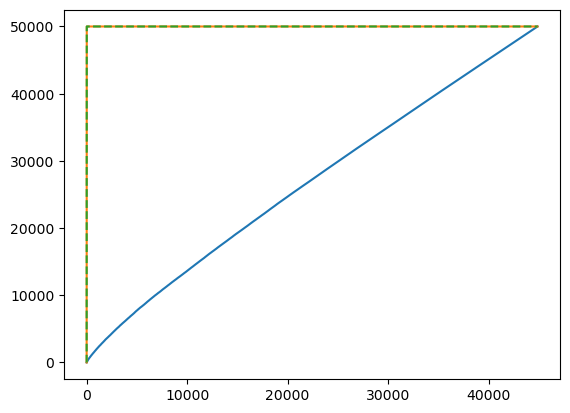

In [113]:

plt.plot(N_over_time)

XX = np.linspace(0, len(N_over_time), len(N_over_time))

# import curve_fit from scipy.optimize
from scipy.optimize import curve_fit
M0 = 100000
n_c = 3


C1_guess = np.sqrt(M0**n_c * n_c/2)

C1 = curve_fit(M_t, XX/10000, N_over_time, p0=[C1_guess])[0][0]

print(f"C1: {C1}, C1_guess: {C1_guess}")
plt.plot(XX, M_t(XX/10000, C1), label="M(t) fit")

plt.plot(XX, M_t(XX, C1_guess), '--', label="M(t) fit")
